# Load and preprocess images

In [105]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array


In [106]:
print(tf.__version__)

2.8.0


In [107]:
import pathlib
train_dir = 'data/Train/'
test_dir = 'data/Test/'
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)


There are 382 total images in train directory and 120 in test directory:

In [108]:
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)

382
120


Each directory contains images of that type of disease. Here is an example of each of them:

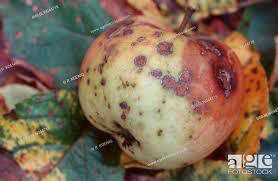

In [109]:
scab = list(train_dir.glob('Scab_Apple/*'))
PIL.Image.open(str(scab[4]))

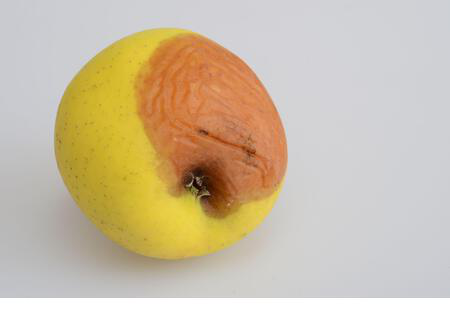

In [110]:
rot = list(train_dir.glob('Rot_Apple/*'))
PIL.Image.open(str(rot[1]))

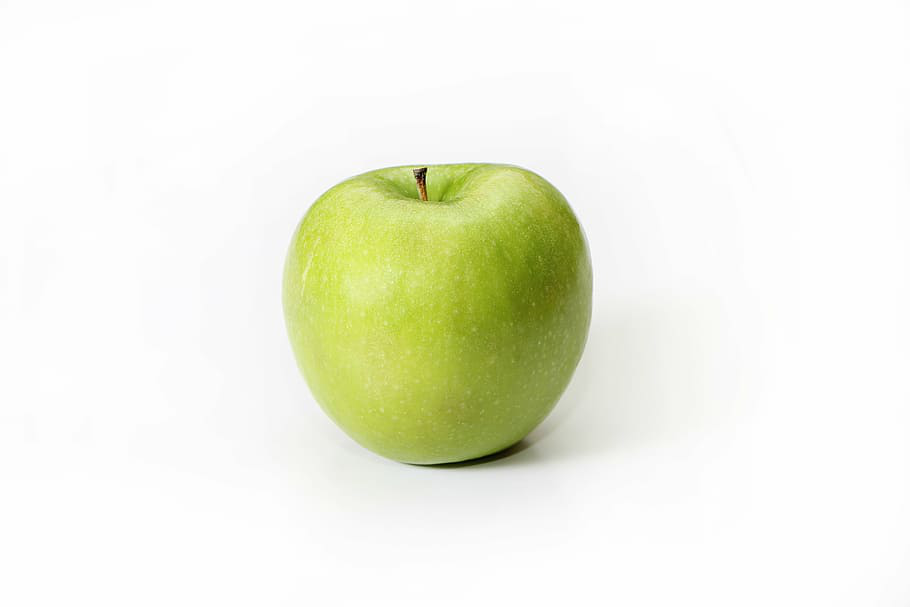

In [111]:
normal = list(train_dir.glob('Normal_Apple/*'))
PIL.Image.open(str(normal[1]))

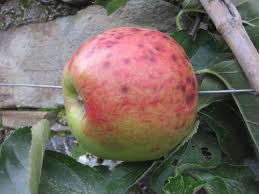

In [112]:

blotch = list(train_dir.glob('Blotch_Apple/*'))
PIL.Image.open(str(blotch[0]))

### Dataset creation

Parameters:

In [113]:
img_height = 360
img_width = 360
batch_size = 32

Train / Validation split

In [114]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# You can print the length of each dataset as follows: from load and preprocess images tutorial notebook
print(tf.data.experimental.cardinality(train_ds).numpy())

Found 382 files belonging to 4 classes.
Using 306 files for training.
10


In [115]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# You can print the length of each dataset as follows: from load and preprocess images tutorial notebook
print(tf.data.experimental.cardinality(val_ds).numpy())

Found 382 files belonging to 4 classes.
Using 76 files for validation.
3


Test

In [116]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
  
# You can print the length of each dataset as follows: from load and preprocess images tutorial notebook
print(tf.data.experimental.cardinality(test_ds).numpy())

Found 120 files belonging to 4 classes.
4


class names in the `class_names` attribute:

In [117]:
class_names = train_ds.class_names
print(class_names)

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']


Take 5 items from ds:

In [142]:
for f in list_ds.take(5):
  print(f.numpy())

b'data/Train/Blotch_Apple/blotch_100.jpg'
b'data/Train/Normal_Apple/normal_23.jpg'
b'data/Train/Normal_Apple/normal_29.jpg'
b'data/Train/Blotch_Apple/blotch_110.jpg'
b'data/Train/Blotch_Apple/blotch_65.jpg'


In [144]:
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy()) # not std yet but what is this?
  

InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [32,360,360,3] and element 1 had shape [18,360,360,3]. [Op:IteratorGetNext]

In [120]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 3)
(32,)


### Visualize the data

Here are the first 16 images from the training dataset.

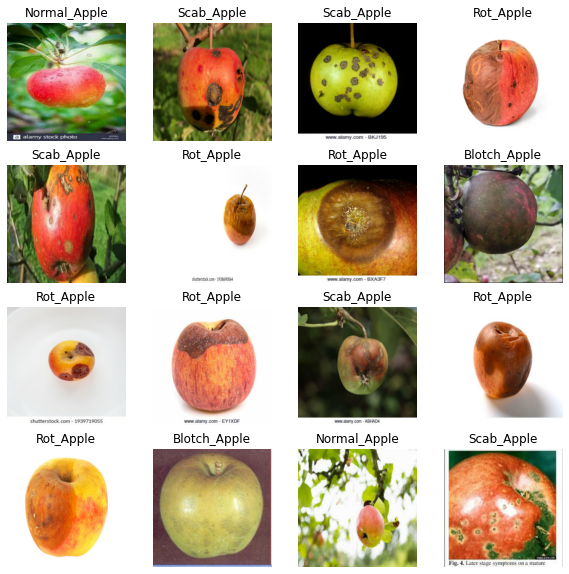

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [122]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [123]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Configure the dataset for performance

In [124]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

In [125]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [126]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [127]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
10/10 [==============================] - 16s 2s/step - loss: 1.3850 - accuracy: 0.3856 - val_loss: 1.1281 - val_accuracy: 0.5000
Epoch 2/3
10/10 [==============================] - 13s 1s/step - loss: 0.8720 - accuracy: 0.6732 - val_loss: 0.6585 - val_accuracy: 0.7368
Epoch 3/3
10/10 [==============================] - 13s 1s/step - loss: 0.6093 - accuracy: 0.7745 - val_loss: 0.8733 - val_accuracy: 0.6053


Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) tutorial.

You may notice the validation accuracy is low compared to the training accuracy, indicating your model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Using tf.data for finer control

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

In [128]:
list_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

The tree structure of the files can be used to compile a `class_names` list.

Write a short function that converts a file path to an `(img, label)` pair:

In [127]:
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (360, 360, 3)
Label:  2
Image shape:  (360, 360, 3)
Label:  2
Image shape:  (360, 360, 3)
Label:  1
Image shape:  (360, 360, 3)
Label:  2
Image shape:  (360, 360, 3)
Label:  1


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [129]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

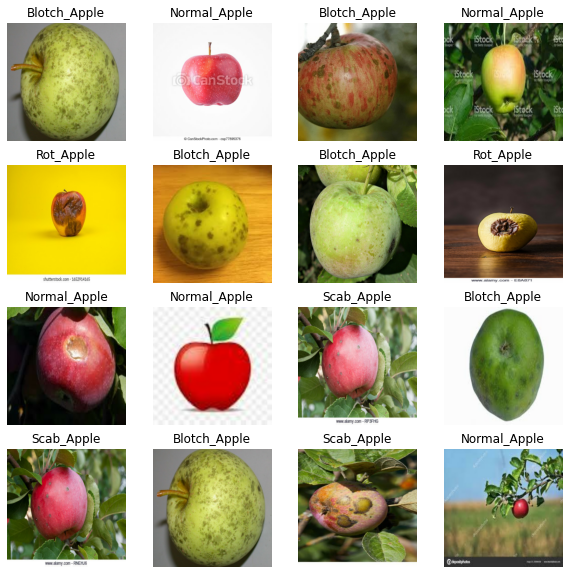

In [129]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by `tf.keras.utils.image_dataset_from_directory` above. You can continue training the model with it. As before, you will train for just a few epochs to keep the running time short.

In [130]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


ValueError: in user code:

    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/macbookpro/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_3" (type Sequential).
    
    Input 0 of layer "max_pooling2d_9" is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (None, None, 358, 358, 32)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, None, 360, 360, 3), dtype=float32)
      • training=True
      • mask=None


In [136]:
# Retrieve a batch of images from the test set
image_batch, label_batch = train_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

InvalidArgumentError: Cannot batch tensors with different shapes in component 0. First element had shape [18,360,360,3] and element 2 had shape [32,360,360,3]. [Op:IteratorGetNext]

You can find a complete example of working with the Flowers dataset and TensorFlow Datasets by visiting the [Data augmentation](../images/data_augmentation.ipynb) tutorial.

## Next steps

This tutorial showed two ways of loading images off disk. First, you learned how to load and preprocess an image dataset using Keras preprocessing layers and utilities. Next, you learned how to write an input pipeline from scratch using `tf.data`. Finally, you learned how to download a dataset from TensorFlow Datasets.

For your next steps:

- You can learn [how to add data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).
- To learn more about `tf.data`, you can visit the [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data) guide.